In [1]:
#####Evolving the parameters of the adaptive mechanism from Williams & Noble (2007)#####
#####and then examining the effect on the "region of viability" for a legged walker#####

import numpy as np
import matplotlib.pyplot as plt
import math

In [42]:
##create CTRNN

def sigmoid(x):
    return 1/(1+np.exp(-x))

class CTRNN():

    def __init__(self,size,dt,duration,slidingwindow,weights,biases,timeconsts):
        self.Size = size                                         # number of neurons in the circuit
        self.States = np.ones(size)                              # state of the neurons
        self.Outputs = np.zeros(size)                            # neuron outputs
        self.PlasticFacilitation = np.zeros(size)                #value of rho for each neuron to use in adaptive mech
        self.dt = dt                                             #size of walking timestep
        self.duration = duration                                 #duration in seconds
        self.time = np.arange(0.0,self.duration,dt)              #timeseries values in seconds
        self.ctrnn_record = np.zeros((size,len(self.time)))      #place to store data of the node firing rates over time
        self.Stepnum = 0                                         #initialize the step count at 0
        self.slidingwindow = slidingwindow                       #how far back to go in timesteps to calculate avg_firingrate (& avg_speed)
        self.max_firingrate = np.zeros(self.Size)                #keep track of the maximum firing rate (for diagnostic b/c place in the cycle varies it)
        self.min_firingrate = np.ones(self.Size)                 #keep track of the minimum firing rate (for diagnostic)
        self.Weights = np.copy(weights)
        self.Biases = np.copy(biases)
        self.invTimeConstants = 1.0/np.copy(timeconsts)
        self.bias_record = np.zeros((size,len(self.time)))       #since parameters of the system are changing under the adaptive mechanism, track them
        self.weight_record = np.zeros((size,size,len(self.time)))#not general, but okay for now
             
    def resetStepcount(self):
        self.Stepnum = 0
        
    def setInputs(self,inputs): #external input to each neuron
        self.Inputs = inputs
    
    def setWeights(self, weights): #weight of connection for each neuron pair, going from row (i) to column (j)
        self.Weights = np.copy(weights)
        
    def randomizeWeights(self):
        self.Weights = np.random.uniform(-10,10,size=(self.Size,self.Size))

    def setBiases(self, biases): #bias shift for each neuron
        self.Biases =  np.copy(biases)
    
    def randomizeBiases(self):
        self.Biases = np.random.uniform(-10,10,size=(self.Size))

    def setTimeConstants(self, timeconstants): #time constant for each neuron
        self.TimeConstants =  np.copy(timeconstants)
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def randomizeTimeConstants(self):
        self.TimeConstants = np.random.uniform(0.1,5.0,size=(self.Size))
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def setAdaptiveTimeConstants(self, adaptiveWtimeconstants, adaptiveBtimeconstants): #time constants for the adaptation of the weights & biases
        self.invadaptWTimeConsts = 1.0/np.copy(adaptiveWtimeconstants)
        self.invadaptBTimeConsts = 1.0/np.copy(adaptiveBtimeconstants)
        
    def randomizeAdaptiveTimeConstants(self):
        self.invadaptWTimeConsts = 1.0/np.random.uniform(10,50,self.Size)
        self.invadaptBTimeConsts = 1.0/np.random.uniform(10,50,self.Size)
        
    def setFacilitationFunctionParams(self,pLows,pHighs,pSlopes): #the parameters for the plastic facilitation function to determine rho
        self.pLows = pLows
        self.pHighs = pHighs
        self.pSlopes = pSlopes #always <0
        
    def randomizeFacilitationFunctionParams(self):
        self.pLows = np.random.uniform(.01,.49,self.Size)  #between .01 and .49 initially, although strictly only has to be lower than pHigh
        self.pHighs = np.random.uniform(.51,.99,self.Size) #between .51 and .99 initially, although strictly only has to be higher than pLow
        self.pSlopes = np.random.uniform(-10,0,self.Size)  #always <0

    def initializeState(self, s):
        self.States = s
        self.Outputs = sigmoid(self.States+self.Biases)
        
    def plasticFacilitationCalc(self): #calculate and update the value of rho for each neuron, using the mean firing rate from the preceding segment of runtime
        for i in range(self.Size):
            if self.Stepnum < self.slidingwindow:
                self.PlasticFacilitation[i] = 0   #yet not enough data to evaluate average firing rate (don't want to use instantaneous firing rate bc it oscillates)
            else:
                avg_firingrate = np.mean(self.ctrnn_record[i,self.Stepnum-self.slidingwindow:self.Stepnum])
                if avg_firingrate > self.max_firingrate[i]:
                    self.max_firingrate[i] = avg_firingrate
                if avg_firingrate < self.min_firingrate[i]:
                    self.min_firingrate[i] = avg_firingrate
                #if self.Stepnum==self.slidingwindow or self.Stepnum == self.duration:
                    #print(avg_firingrate)
                if  avg_firingrate < self.pLows[i]:
                    self.PlasticFacilitation[i] = self.pSlopes[i]*(avg_firingrate - self.pLows[i] )
                elif avg_firingrate > self.pHighs[i]:
                    self.PlasticFacilitation[i] = self.pSlopes[i]*(avg_firingrate - self.pHighs[i])
                else:
                    self.PlasticFacilitation[i] = 0  #if in range, no change 
    
    def updateBiases(self,adapt_vars): #use the value of rho for each neuron to dynamically change biases if allowed to change
        if not np.all(adapt_vars==0):
            for i in range(self.Size):
                self.Biases[i] += self.dt * self.invadaptBTimeConsts[i] * self.PlasticFacilitation[i]*adapt_vars[i]
    
    def updateWeights(self,adapt_vars): #use the value of rho for each neuron to dynamically change the incoming weights to that neuron which are allowed to change
        if not np.all(adapt_vars==0):
            for j in range(self.Size):
                adapt_vars = np.resize(adapt_vars,(self.Size,self.Size))
                incomingWeights = self.Weights[:,j]
                incoming_adapt_vars = adapt_vars[:,j] #boolean values corresponding to the incoming weights which indicate whether they are allowed to change
                incomingWeights += self.dt * self.invadaptWTimeConsts[j] * self.PlasticFacilitation[j] * np.absolute(incomingWeights)*incoming_adapt_vars
                self.Weights[:,j] = incomingWeights
        
    def ctrnnstep(self,adapt,adapt_vars): #use the value of the weights and outputs to change the state of each neuron
        #if adapt = true, then we are implementing the adaptive mechanism
        #adapt_vars is a numpy array of booleans as long as the number of CTRNN parameters, not including time constants
        #a true/1 in the relevant position indicates that that parameter can change
        netinput = self.Inputs + np.dot(self.Weights.T, self.Outputs)
        self.States += self.dt * (self.invTimeConstants*(-self.States+netinput))        
        self.Outputs = sigmoid(self.States+self.Biases)
        self.ctrnn_record[:,self.Stepnum] = self.Outputs
        if adapt == True:
            self.bias_record[:,self.Stepnum]=self.Biases
            self.weight_record[:,:,self.Stepnum]=self.Weights
            self.plasticFacilitationCalc()
            self.updateBiases(adapt_vars[0:self.Size])
            self.updateWeights(adapt_vars[self.Size:])
        self.Stepnum += 1
        
    def plot(self):
        for i in range(self.Size):
            lab = "Neuron %d" %i
            plt.plot(self.time,self.ctrnn_record[i],label=lab)
        plt.title("Neural Activity")
        plt.xlabel("Time (s)")
        plt.ylabel("Firing Rate")
        plt.rcParams["figure.figsize"] = (20,3)
        plt.legend()
            

In [41]:
a = np.array([[0,0],[0,0]])
if not np.all(a == 0):
    print('yay')

In [8]:
##One-legged walker with interneuron

# Constants
LegLength = np.array([15,15])
MaxLegForce = 0.05
ForwardAngleLimit = math.pi/6.0
BackwardAngleLimit = -math.pi/6.0
MaxVelocity = 6.0
MaxTorque = 0.5
MaxOmega = 1.0

class LeggedAgent:

    def __init__(self,l,dt):   #l= number of legs, l=1 for me
        self.legs = l
        self.ix = 0.0
        self.iy = 0.0
        self.cx = 0.0
        self.cy = 0.0
        self.vx = 0.0
        self.footstate = np.zeros(l)
        self.angle = np.repeat(np.array(ForwardAngleLimit),l)
        self.omega = np.zeros(l)
        self.forwardForce = np.zeros(l)
        self.backwardForce = np.zeros(l)
        self.jointX = np.repeat(self.cx,l)
        self.jointY = np.repeat(self.cy + 12.5,l)
        self.footX = self.jointX + LegLength * np.sin(self.angle)
        self.footY = self.jointY + LegLength * np.cos(self.angle)
        self.stepsize = dt

    def state(self):
        return np.array([self.angle, self.omega, self.footstate])

    def out(self):
        return np.array([self.angle * 5.0/ForwardAngleLimit])

    def walkstep(self, u):
        force = np.zeros(self.legs)
        for i in range(self.legs):
            # Update the leg effectors
            if (u[i] > 0.5):
                self.footstate[i] = 1
                self.omega[i] = 0
                self.forwardForce[i] = 2 * (u[i] - 0.5) * MaxLegForce;
                self.backwardForce[i] = 0.0
            else:
                self.footstate[i] = 0
                self.forwardForce[i] = 0.0
                self.backwardForce[i] = 2 * (0.5 - u[i]) * MaxLegForce;

        # Compute force applied to the body
        for i in range(self.legs):
            f = self.forwardForce[i] - self.backwardForce[i]
            if self.footstate[i] == 1.0:
                if ((self.angle[i] >= BackwardAngleLimit and self.angle[i] <= ForwardAngleLimit) or
                    (self.angle[i] < BackwardAngleLimit and f < 0) or
                    (self.angle[i] > ForwardAngleLimit and f > 0)):
                    force[i] = f
        totalforce = sum(force)

        # Update the position of the body
        self.vx = self.vx + self.stepsize * totalforce
        if (self.vx < -MaxVelocity):
            self.vx = -MaxVelocity
        if (self.vx > MaxVelocity):
            self.vx = MaxVelocity
        self.cx = self.cx + self.stepsize * self.vx
        
        # Update the leg geometry
        for i in range(self.legs):
            self.jointX[i] = self.jointX[i] + self.stepsize * self.vx
            if (self.footstate[i] == 1.0):
                angle = math.atan2(self.footX[i] - self.jointX[i], self.footY[i] - self.jointY[i])
                self.omega[i] = (angle - self.angle[i])/self.stepsize
                self.angle[i] = angle
            else:
                self.vx = 0.0
                self.omega[i] = self.omega[i] + self.stepsize * MaxTorque * (self.backwardForce[i] - self.forwardForce[i])
                if (self.omega[i] < -MaxOmega):
                    self.omega[i] = -MaxOmega
                if (self.omega[i] > MaxOmega):
                    self.omega[i] = MaxOmega
                self.angle[i] = self.angle[i] + self.stepsize * self.omega[i]
                if (self.angle[i] < BackwardAngleLimit):
                    self.angle[i] = BackwardAngleLimit
                    self.omega[i] = 0
                if (self.angle[i] > ForwardAngleLimit):
                    self.angle[i] = ForwardAngleLimit
                    self.omega[i] = 0
                self.footX[i] = self.jointX[i] + LegLength[i] * math.sin(self.angle[i])
                self.footY[i] = self.jointY[i] + LegLength[i] * math.cos(self.angle[i])

        # If any foot is too far back, the body becomes "unstable" and forward motion ceases
        for i in range(self.legs):
            if (self.cx - self.footX[i] > 20):
                self.vx = 0.0
        
    
    def run(self,n,adapt,adapt_vars):  #duration is in steps, n is an object of class CTRNN,adapt is boolean about whether adaptive mech is implemented
        self.cx = 0.0
        self.vx = 0.0
        self.walker_record = np.zeros(len(n.time))
    
        for t in range(len(n.time)): 
            #print("walkstep",t)
            n.ctrnnstep(adapt,adapt_vars)
            self.walkstep(n.Outputs)
            self.walker_record[t] = self.cx
            

In [9]:
# Parameters for a whole lifetime run of an agent
network_size = 2
dt = .1
duration = 1000 #in seconds >> slidingwindow*dt
slidingwindow = 400 #in timesteps >> period of oscillation and <<duration/dt
adapt_vars = np.array([1,1,1,1,1,1])

#starting condition is a highly fit neuron with these parameters, from cluster ii (unpublished work)
#start_timeconsts = np.array([.0549809, 8.13544])
#start_weights = np.array([[15.9545, 11.1703],[-11.9525,12.817]])
#start_biases = np.array([-3.20922,-13.7271])

#starting condition is a highly fit neuron with these parameters, from cluster i? (unpublished work)
#start_timeconsts = np.array([.6, 9.9])
#start_weights = np.array([[15.7, -9.4],[12.9, 9.6]])
#start_biases = np.array([-12.7, 2.29])

#slightly worse than ideal so that the adaptive mech has something to improve
#start_timeconsts = np.array([.6, 9.9])
#start_weights = np.array([[15.7, -9.4],[12.0, 10.0]])
#start_biases = np.array([-12.7, 2.0])

#non-oscillator
start_timeconsts = np.array([.6, 9.9])
start_weights = np.array([[17.0, -14.0],[10.0, 10.0]])
start_biases = np.array([-12.0, 2.0])


class convert_genome():  #converting the genome array into a form that can be input to the CTRNN functions
    def __init__(self,genome):
        self.genome = genome
    
    def convert(self):
        self.pLows = self.genome[:,0]
        self.pHighs = self.genome[:,1]
        self.pSlopes = self.genome[:,2]
        self.Wtaus = self.genome[:,3]
        self.Btaus = self.genome[:,4]
        
              
def adaptiveevoltrial(genome,plot,calc_start_speed):
    g = convert_genome(genome)
    g.convert()
    N = CTRNN(network_size,dt,duration,slidingwindow,start_weights,start_biases,start_timeconsts)
    N.initializeState(np.array([-10.0,-10.0]))
    N.setInputs(np.zeros(2))
    N.setAdaptiveTimeConstants(g.Wtaus,g.Btaus)
    N.setFacilitationFunctionParams(g.pLows,g.pHighs,g.pSlopes)
    dur = len(N.time)
    if calc_start_speed == True:
        A = LeggedAgent(1,dt)
        A.run(N,False,adapt_vars) #how fast did it walk given the parameters it started with
        N.resetStepcount()
        N.initializeState(np.array([-10.0,-10.0]))
        start_speed = (A.walker_record[-1]-A.walker_record[1000])/(dur-1000) #take out transients and ensure it can't benefit from taking one single "step"
    else:
        start_speed = "n/a"
    A = LeggedAgent(1,dt)  #must reinitialize A each time so the small little forward push can happen
    A.run(N,True,adapt_vars) #perform the adaptive period
    if plot == True: #the plot will reflect the adaptive period
        N.plot()
        plt.show()
    bias_record = N.bias_record
    weight_record = N.weight_record
    N.resetStepcount()
    N.initializeState(np.array([-10.0,-10.0]))
    A = LeggedAgent(1,dt)
    A.run(N,False,adapt_vars)
    end_speed = (A.walker_record[-1]-A.walker_record[1000])/(dur-1000) #how fast does it walk given the parameters that it ended up with at the end of the adative period
    return start_speed,end_speed,N.Weights,N.Biases,N.invTimeConstants,bias_record,weight_record

    

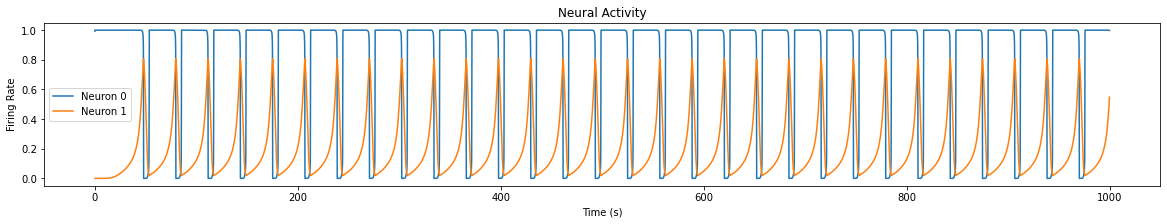

In [17]:
#test to see if the parameters produce oscillations without any adaptive mechanism in place

#starting condition is a highly fit neuron with these parameters, from cluster ii (unpublished work)
start_timeconsts = np.array([.0549809, 8.13544])
start_weights = np.array([[15.9545, 11.1703],[-11.9525,12.817]])
start_biases = np.array([-3.20922,-13.7271])

#start_timeconsts = np.array([.6, 9.9])
#start_weights = np.array([[15.7, -9.4],[12.0, 10.0]])
#start_biases = np.array([-12.7, 2.0])

N = CTRNN(network_size,dt,duration,slidingwindow,start_weights,start_biases,start_timeconsts)
N.initializeState(np.array([-10.,-10.]))
N.setInputs(np.zeros(2))
A = LeggedAgent(1,dt)
A.run(N,False,adapt_vars)
N.plot()

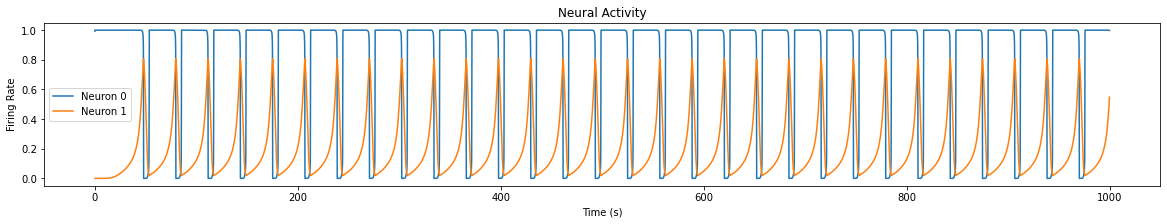

(0.04667211138822983,
 0.04667211138822983,
 array([[ 15.9545,  11.1703],
        [-11.9525,  12.817 ]]),
 array([ -3.20922, -13.7271 ]),
 array([18.18813442,  0.12291898]),
 array([[ -3.20922,  -3.20922,  -3.20922, ...,  -3.20922,  -3.20922,
          -3.20922],
        [-13.7271 , -13.7271 , -13.7271 , ..., -13.7271 , -13.7271 ,
         -13.7271 ]]),
 array([[[ 15.9545,  15.9545,  15.9545, ...,  15.9545,  15.9545,
           15.9545],
         [ 11.1703,  11.1703,  11.1703, ...,  11.1703,  11.1703,
           11.1703]],
 
        [[-11.9525, -11.9525, -11.9525, ..., -11.9525, -11.9525,
          -11.9525],
         [ 12.817 ,  12.817 ,  12.817 , ...,  12.817 ,  12.817 ,
           12.817 ]]]))

In [43]:
#to test to see if the resulting system parameters oscillate on their own, initialize with the final system parameters and nullify the adaptive mechanism

adapt_vars = np.array([1,1,0,0,0,0])

genome2 = np.array([[ 0.21335502,  0.85251558, -9.68694597, 48.06313098, 31.43235441],[ 0.05402182,  0.39790152, -2.21455117, 49.2815298,  43.0356333 ]])

null_genome = np.array([[0,1,-.1,50,50],[0,1,-.1,50,50]])

#adaptiveevoltrial(genome2,True,True)

adaptiveevoltrial(null_genome,True,True)

In [44]:
#Microbial evolutionary algorithm with continuously valued genes
class Microbial:
    def __init__(self,popsize,generations,neuronnumber,genomelength,recombprob,mutatprob):
        self.popsize = popsize                                    #number of individuals
        self.generations = generations                            #generations
        self.pop = np.zeros((popsize,neuronnumber,genomelength))  #initialize population genome structures
        self.neuronnumber = neuronnumber                          #how many neurons in the ctrnn
        self.genomelength = genomelength                          #number of adaptive parameters to evolve for each neuron
        self.recombprob = recombprob                              #probability that loser will take one of winner's genes
        self.mutatprob = mutatprob                                #probability that each gene of loser will be mutated by random amount
        self.fitnesses = np.zeros(popsize)                        #initialize fitness tracking structure
        self.avgHistory = np.zeros(generations)                   #initialize tracker of average fitness over time
        self.bestHistory = np.zeros(generations)                  #initialize tracker of best fitness over time
        
    def initialstateset(self,weights,biases,timeconsts):          #indicate parameter set (parameters of CTRNN) that all adaptive systems start at
        self.initialweights = np.copy(weights)
        self.initialbiases = np.copy(biases)
        self.initialtimeconsts = np.copy(timeconsts)
        
    def fitstats(self):                                           #report/record statistics
        bestind = self.pop[np.argmax(self.fitnesses)]
        bestfit = np.max(self.fitnesses)
        avgfit = np.mean(self.fitnesses)
        self.avgHistory[self.gen]=avgfit
        self.bestHistory[self.gen]=bestfit
        return avgfit, bestfit, bestind
        
    def plotfit(self):                                            #plot statistics
        plt.plot(self.bestHistory,label="Best Indiv.")
        plt.plot(self.avgHistory,label="Avg. Fitness")
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.title("Best and average fitness")
        plt.legend()
        plt.show()
        
    def randomizepop(self):
        for i in range(self.popsize):
            for j in range(self.neuronnumber):
                pLow = np.random.uniform(0,.5)                    #initializing the pLow to be in the lower half of the range. Maybe will speed things up?
                self.pop[i,j,0] = pLow         
                self.pop[i,j,1] = np.random.uniform(pLow,1)       #random upper bound higher than given lower bound
                self.pop[i,j,2] = np.random.uniform(-10,0)        #random negative slope
                self.pop[i,j,3:5] = np.random.uniform(10,50,2)   #time constants for the weight and bias fluctuation, must be slower than the timecourse of the neurons
    def run(self):
        #calculate all fitness once
        for i in range(self.popsize):
            self.fitnesses[i] = np.copy(adaptiveevoltrial(self.pop[i],False,False)[1]) #the end speed is the measure of fitness
        # Evolutionary loop
        for g in range(self.generations):
            self.gen = g
            for i in range(self.popsize):
                # Step 1: Pick 2 individuals
                a = i #ensure all individuals get tried once
                b = np.random.randint(0,self.popsize-1)
                while (a==b):   # Make sure they are two different individuals
                    b = np.random.randint(0,self.popsize-1)
                # Step 2: Compare their fitness
                if (self.fitnesses[a] > self.fitnesses[b]):
                    winner = a
                    loser = b
                else:
                    winner = b
                    loser = a
                #print("loser fitness",self.fitnesses[loser])
                #print("winner fitness",self.fitnesses[winner])
                # Step 3: Transfect loser with winner --- Could be made more efficient using Numpy
                for n in range(self.neuronnumber):
                    if (np.random.random() < self.recombprob): #target range values transfer together
                        self.pop[loser,n,0:2] = self.pop[winner,n,0:2]
                    for l in range(2,5): #all other aspects of genome are independent
                        if (np.random.random() < self.recombprob):
                            self.pop[loser,n,l] = self.pop[winner,n,l]
                    for l in range(self.genomelength):
                        # Step 4: Mutate loser and make sure new organism stays within bounds
                        if (np.random.random() < self.mutatprob):
                            self.pop[loser,n,l] += .1*np.random.normal()                              #####limit the target range size because otherwise theyll just say 0 to 1 and keep the fitness they are given
                            if self.pop[loser,n,0]>= self.pop[loser,n,1]: #cannot adjust either of the cutoffs to be on the wrong side
                                distance = self.pop[loser,n,0]-self.pop[loser,n,1] #how far in front of the high value is the low value?
                                self.pop[loser,n,0] += -1.5*distance               #then, push them apart to be centered around the high value
                                self.pop[loser,n,1] += .5*distance
                    self.pop[loser,n] = np.clip(self.pop[loser,n],[0,0,-20,10,10],[1,1,0,100,100])   #appropriate upper and lower bounds for the adaptive mechanism? 
                    
                # Save fitness
                self.fitnesses[loser] = np.copy(adaptiveevoltrial(self.pop[loser],False,False)[1]) #update fitness to new endspeed
            # Report statistics every generation
            self.fitstats()


In [45]:
#Microbial evolution for the adaptive mechanism parameters, all starting from the fit specimen identified three boxes up
populationsize = 10
generations = 20
recombprob = .1
mutatprob = .08
adapt_vars = np.array([1,0,1,0,0,0])
print(adapt_vars)


#reconfirm the starting conditions on which you will evolve the adaptive mechanism
#non-oscillator, in my experience impossible to adapt
start_timeconsts = np.array([.6, 9.9])
start_weights = np.array([[17.0, -14.0],[10.0, 10.0]])
start_biases = np.array([-12.0, 2.0])

#cluster i params, initial fitness .046
#start_timeconsts = np.array([.0549809, 8.13544])
#start_weights = np.array([[15.9545, 11.1703],[-11.9525,12.817]])
#start_biases = np.array([-3.20922,-13.7271])

#fitness .05513
#start_timeconsts = np.array([.6, 9.9])
#start_weights = np.array([[15.7, -9.4],[12.0, 10.0]])
#start_biases = np.array([-12.7, 2.0])


M = Microbial(populationsize,generations,2,5,recombprob,mutatprob)
M.initialstateset(start_weights,start_biases,start_timeconsts)
M.randomizepop()
M.run()

[1 0 1 0 0 0]


[[ 0.44104212  0.90631415 -0.8787701  32.32322665 26.58294887]
 [ 0.31647206  0.59186772 -2.92135789 47.36707283 37.02879527]]


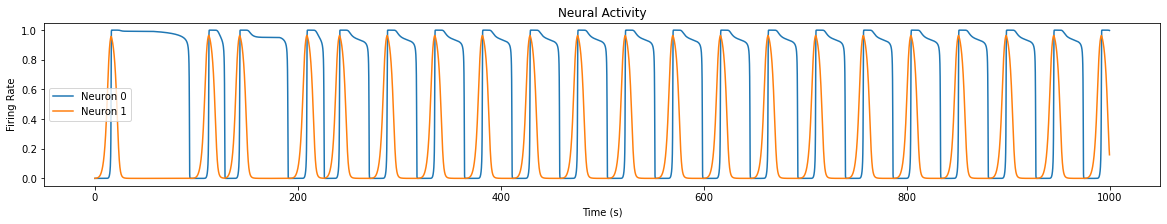

(0.0,
 0.041852997004979256,
 array([[ 15.755238, -14.      ],
        [ 10.      ,  10.      ]]),
 array([-12.09244568,   2.        ]),
 array([1.66666667, 0.1010101 ]),
 array([[-12.        , -12.        , -12.        , ..., -12.09244568,
         -12.09244568, -12.09244568],
        [  2.        ,   2.        ,   2.        , ...,   2.        ,
           2.        ,   2.        ]]),
 array([[[ 17.      ,  17.      ,  17.      , ...,  15.755238,
           15.755238,  15.755238],
         [-14.      , -14.      , -14.      , ..., -14.      ,
          -14.      , -14.      ]],
 
        [[ 10.      ,  10.      ,  10.      , ...,  10.      ,
           10.      ,  10.      ],
         [ 10.      ,  10.      ,  10.      , ...,  10.      ,
           10.      ,  10.      ]]]))

In [46]:
#check the timeseries of the system with the best adaptive mechanism
best_genome=M.fitstats()[2]
print(best_genome)
adaptiveevoltrial(best_genome,True,True)

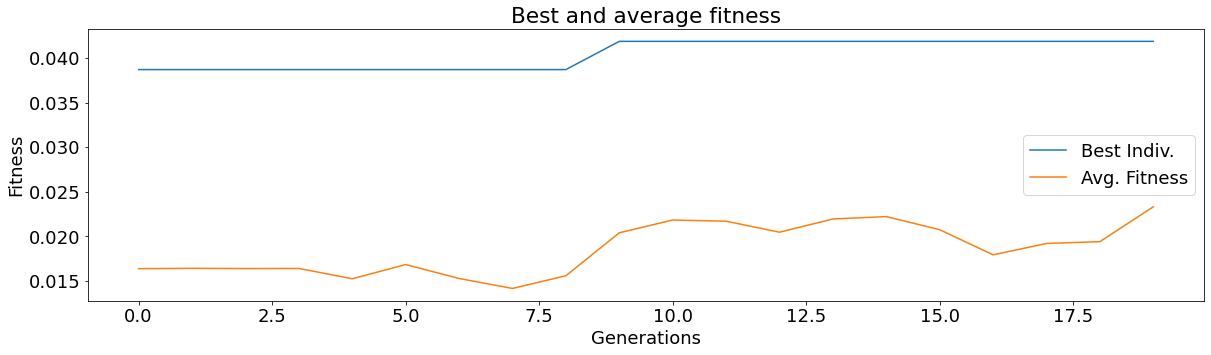

(0.023312138385434673,
 0.041852997004979256,
 array([[ 0.44104212,  0.90631415, -0.8787701 , 32.32322665, 26.58294887],
        [ 0.31647206,  0.59186772, -2.92135789, 47.36707283, 37.02879527]]))

In [47]:
plt.figure(figsize=(20,5))
plt.rcParams.update({'font.size': 18})
plt.plot(M.bestHistory,label="Best Indiv.")
plt.plot(M.avgHistory,label="Avg. Fitness")
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Best and average fitness")
plt.legend()
plt.show()
M.fitstats()

In [49]:
#This is the genome of an adaptive mechanism which actually improved fitness from its starting condition
#master_genome = M.fitstats()[2]
#master_genome1 = np.array([[.342,.847,-6.824,10,25],[.109,.912,-.667,10,25]]) #estimate of mech evolved in trial 1
#master_genome2 = np.array([[3.53617261e-01,9.63496609e-01,-2.16225005e+00,3.45731610e+01,1.14343615e+01],[1.90165928e-02,7.74976724e-01,-4.42876912e+00,1.31861492e+01,4.87389291e+01]]) #mech evolved in trial 2
#master_genome3 = np.array([[ 0.1854404 ,  0.96829901, -5.15169612, 44.83251575, 10.2690389 ],[ 0.06586382,  0.84109247, -7.41369611, 45.61788044, 13.43093142]])

master_genome = best_genome
print("Master genome:",master_genome) #pick which mech you want to use for analysis

Master genome: [[ 0.44104212  0.90631415 -0.8787701  32.32322665 26.58294887]
 [ 0.31647206  0.59186772 -2.92135789 47.36707283 37.02879527]]


In [56]:
#Create a grid of starting points to determine which lie in the basin of attraction
num_pts = 30  #number of points spread along each axis in the plane

#If a given variable is projected out of a slice, set it to its value in the highest fitness cluster i
#walker so that fitness landscapes can be compared
set_b1 =  -3.20922
set_b2 =  -13.7271
set_w11 =  15.9545
set_w12 =  11.1703
set_w21 = -11.9525
set_w22 =  12.817
tau1 =     0.549809
tau2 =     8.13544

#a set of variables not from the data that have more success
#set_b1=2.65
#set_b2=-13.7271
#set_w11=14.2516
#set_w12=11.1703
#set_w21=-13.418
#set_w22=12.817

#for each slice of interest, define the range of interest for each variable parameter and create the slice's grid for plotting later
range1_b1 = np.linspace(-15,15,num_pts)
range1_w11= np.linspace(0,16,num_pts)
slice1b1,slice1w11 = np.meshgrid(range1_b1,range1_w11)

#And create the parameter lists necessary to test that slice
IClist1 = np.zeros((num_pts**2,8))
for i in range(num_pts):
    for j in range(num_pts):
        IClist1[(i*num_pts)+j,:] = np.array([tau1,tau2,range1_b1[i],set_b2,range1_w11[j],set_w12,set_w21,set_w22])

range2_b2 = np.linspace(-16,5,num_pts)
range2_w22= np.linspace(-12,16,num_pts)
slice2b2,slice2w22 = np.meshgrid(range2_b2,range2_w22)

IClist2 = np.zeros((num_pts**2,8))
for i in range(num_pts):
    for j in range(num_pts):
        IClist2[(i*num_pts)+j,:] = np.array([tau1,tau2,set_b1,range2_b2[i],set_w11,set_w12,set_w21,range2_w22[j]])
        
range3_b1 = np.linspace(-10,5,num_pts)
range3_b2 = np.linspace(-16,-5,num_pts)
slice3b1,slice3b2 = np.meshgrid(range3_b1,range3_b2)

IClist3 = np.zeros((num_pts**2,8))
for i in range(num_pts):
    for j in range(num_pts):
        IClist3[(i*num_pts)+j,:] = np.array([tau1,tau2,range3_b1[i],range3_b2[j],set_w11,set_w12,set_w21,set_w22])
        
range4_b2 = np.linspace(-16,-3,num_pts)
range4_w12= np.linspace(0,16,num_pts)
slice4b2,slice4w12 = np.meshgrid(range4_b2,range4_w12)

IClist4 = np.zeros((num_pts**2,8))
for i in range(num_pts):
    for j in range(num_pts):
        IClist4[(i*num_pts)+j,:] = np.array([tau1,tau2,set_b1,range4_b2[i],set_w11,range4_w12[j],set_w21,set_w22])


In [121]:
#instead of changing in the for loop, change the slice you're investigating here 
master_IClist = np.copy(IClist2)

#initialize structure in which to store the final fitness of the system after its run  
final_fitnesses = np.zeros(len(master_IClist))
max_IC_fitness = 0
max_IC = np.zeros(len(master_IClist[0]))

#run the adaptive system starting from each of the initial conditions and record fitness
for i in range(num_pts**2):
    start_timeconsts = master_IClist[i,0:2]
    start_biases = master_IClist[i,2:4]
    start_weights = np.array([master_IClist[i,4:6],master_IClist[i,6:8]])
    W = adaptiveevoltrial(null_genome,False,False)[1]
    final_fitnesses[i]=W
    #print(W)
    if W > max_IC_fitness:
        max_IC_fitness = W
        j = i%num_pts
        max_IC = np.array([int((i-j)/num_pts),j]) #convert position in list into eventual index in the fitness matrix
        #print("start-end",adaptiveevoltrial(master_genome,True,True)[0:2])

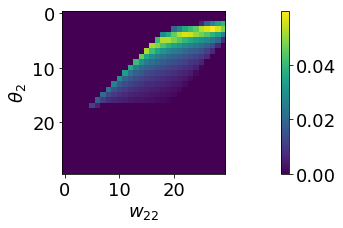

In [122]:
final_fitness_grid = np.reshape(final_fitnesses,(num_pts,num_pts))
#final_fitnesses
plt.imshow(final_fitness_grid)
plt.xlabel('$w_{22}$')
plt.xlim()
plt.ylabel(r'$\theta_{2}$')
plt.colorbar()

In [ ]:
#cell used to save data as variables during runs
# final_fitness_ICgrid1 = final_fitness_grid
# final_fitness_ICgrid2 = final_fitness_grid
# final_fitness_ICgrid3 = final_fitness_grid
# final_fitness_ICgrid4 = final_fitness_grid

In [84]:
#save those variables externally to the notebook
# np.savetxt('final_fitness_ICgrid1.csv', final_fitness_ICgrid1, delimiter=',') 
# np.savetxt('final_fitness_ICgrid2.csv', final_fitness_ICgrid2, delimiter=',') 
# np.savetxt('final_fitness_ICgrid3.csv', final_fitness_ICgrid3, delimiter=',') 
# np.savetxt('final_fitness_ICgrid4.csv', final_fitness_ICgrid4, delimiter=',') 

In [18]:
#import variables back from folder
final_fitness_ICgrid1=np.loadtxt('final_fitness_ICgrid1.csv', delimiter=',')
final_fitness_ICgrid2=np.loadtxt('final_fitness_ICgrid2.csv', delimiter=',')
final_fitness_ICgrid3=np.loadtxt('final_fitness_ICgrid3.csv', delimiter=',') 
final_fitness_ICgrid4=np.loadtxt('final_fitness_ICgrid4.csv', delimiter=',') 

872

initial params achieving highest fitness: [  0.549809     8.13544     -3.20922     -5.13793103  15.9545
  11.1703     -11.9525      -2.34482759]


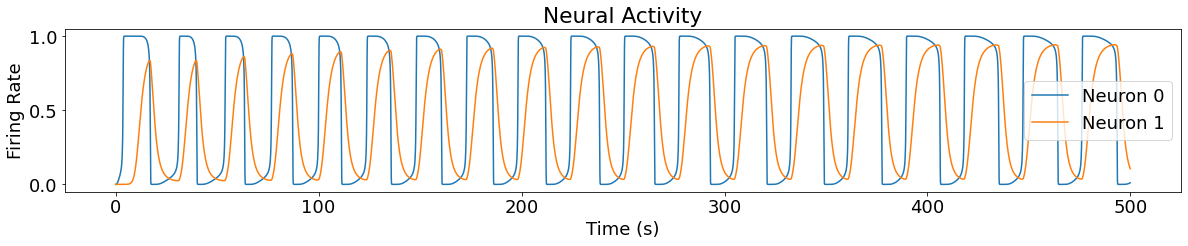

starting speed: 0.008548043308413867 final speed: 0.02542676449157625


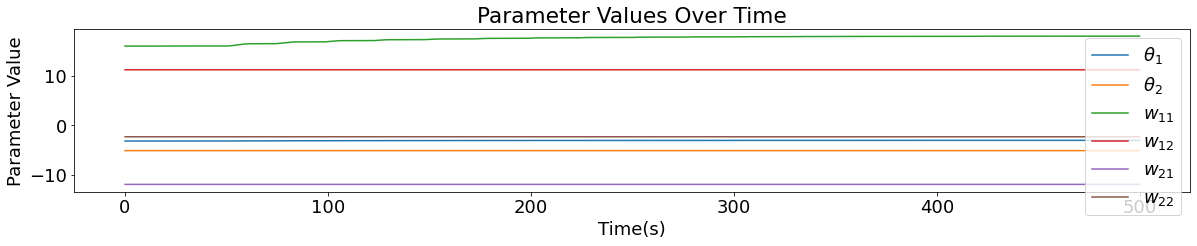

In [123]:
#final_fitness_grid = final_fitness_ICgrid4 #<----------this should match
                                                      # |
#if have just created the fitness maps,use:           # |       
#max_IND = (max_IC[0]*num_pts) + max_IC[1]            # |
                                                      # |
#if loaded them in, use:                              # |
#max_IND = np.argmax(final_fitness_grid)               # |
                                                      # |
fittest_params = IClist2[460] #<--------------------| this
print('initial params achieving highest fitness:', fittest_params)

start_timeconsts = fittest_params[0:2]
start_biases = fittest_params[2:4]
start_weights = np.array([fittest_params[4:6],fittest_params[6:8]])

duration=500
N = CTRNN(network_size,dt,duration,slidingwindow,start_weights,start_biases,start_timeconsts)
N.initializeState(np.array([-10.,-10.]))
N.setInputs(np.zeros(2))

#graphing trajectories of parameters over the space
bias_record,weight_record = adaptiveevoltrial(master_genome,True,True)[5:]
startspeed,endspeed,final_weights,final_biases = adaptiveevoltrial(master_genome,False,True)[:4]

print('starting speed:', startspeed, 'final speed:', endspeed)
#print('final weights:', final_weights)
#print('final biases:', final_biases)



#plot how each parameter changes over time
plt.plot(N.time,bias_record[0,:],label=r"$\theta_1$")
plt.plot(N.time,bias_record[1,:],label=r'$\theta_2$')
plt.plot(N.time,weight_record[0,0,:],label='$w_{11}$')
plt.plot(N.time,weight_record[0,1,:],label='$w_{12}$')
plt.plot(N.time,weight_record[1,0,:],label='$w_{21}$')
plt.plot(N.time,weight_record[1,1,:],label='$w_{22}$')
plt.title('Parameter Values Over Time')
plt.xlabel('Time(s)')
plt.ylabel('Parameter Value')
plt.legend()
plt.show()

In [124]:
def find_nearest(a, a0): #from a stack overflow posting
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

bias_record_index = np.zeros(len(bias_record[0]))
weight_record_index = np.zeros(len(weight_record[0,0]))

for i in range(len(bias_record[0])):
    bias_record_index[i] = find_nearest(range2_b2,bias_record[1,i])         #these must be adjusted to match slice as well
    weight_record_index[i] = find_nearest(range2_w22,weight_record[1,1,i])  #and in slice 3 there is no weight
weight_record_index 

array([10., 10., 10., ..., 10., 10., 10.])

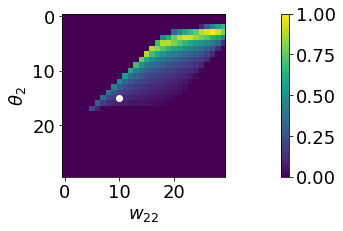

In [125]:
plt.imshow(final_fitness_grid)
plt.xlabel('$w_{22}$') #change to match slice
plt.xlim()
plt.ylabel(r'$\theta_{2}$') #change to match slice
plt.plot(weight_record_index,bias_record_index,'r')
plt.scatter(weight_record_index[0],bias_record_index[0], marker='o', color='red')
plt.scatter(weight_record_index[-1],bias_record_index[-1],marker='o',color='white')
plt.colorbar()